In [34]:
import sys
sys.path.append("../Pupillengröße/Skripte/")

import os
import numpy as np
from pyplr import utils
import pandas as pd
from classPLRfromGitHub import PLR
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt
from IPython.display import display

#import tkinter as tk
#from tkinter import simpledialog
import sys
import importlib
import checkdataPLR
import pup_config
import pup_util
import importlib
importlib.reload(pup_config)
importlib.reload(pup_util)

#from preprocessing import ProcessConfig
# import checkdataPLR


<module 'pup_util' from '/Users/Katharina/Desktop/Pupille/Lichtreflex/../Pupillengröße/Skripte/pup_util.py'>

PJ25_A_PLR1/
    annotation_timestamps.npy
    exports/
        000/
            annotations.csv
            export_info.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            pupil_positions.csv.pickle
    pyplr_analysis/
ProcessConfig(eyenum=0, column='diameter', sfactor=1, data_dir='/Users/Katharina/Desktop/Beispieldaten', subject_id='PJ25_A_PLR1', condition='BaselineA', out_dir='/Users/Katharina/Desktop/PLR preprocessed')
************************************************************
*********************** PJ25_A_PLR1 ************************
************************************************************


'SUBJECT:'

{'root': '/Users/Katharina/Desktop/Beispieldaten/PJ25/PJ25_A_PLR1',
 'id': 'PJ25_A_PLR1',
 'data_dir': '/Users/Katharina/Desktop/Beispieldaten/PJ25/PJ25_A_PLR1/exports/000',
 'out_dir': '/Users/Katharina/Desktop/Beispieldaten/PJ25/PJ25_A_PLR1/pyplr_analysis'}

Loaded 12657 samples
Loaded 4 events


,index,label,duration
timestamp,,,
32865.570818,773,LIGHT_ON,NaN
32880.782994,1227,LIGHT_ON,NaN
32895.966687,1680,LIGHT_ON,NaN
32911.146571,2133,LIGHT_ON,NaN


Extracted ranges for 4 events


eye_id  confidence   diameter  method  diameter_original  \
event onset                                                             
0     0           0    1.000000  78.121066     NaN          78.026413   
      1           0    1.000000  78.126830     NaN          78.269066   
      2           0    1.000000  78.132826     NaN          78.327133   
      3           0    1.000000  78.138643     NaN          78.043365   
      4           0    1.000000  78.143904     NaN          78.410706   
...             ...         ...        ...     ...                ...   
3     1195        0    0.938983  71.607619     NaN          71.642372   
      1196        0    1.000000  71.596335     NaN          71.605507   
      1197        0    1.000000  71.584430     NaN          71.762199   
      1198        0    1.000000  71.572064     NaN          71.506531   
      1199        0    1.000000  71.559418     NaN          71.644676   

             diameter_rec  diameter_rec_interp      orig_idx  color  \
event onset                                                           
0     0         78.026413            78.026413  32864.574042    NaN   
      1         78.269066            78.269066  32864.582087    NaN   
      2         78.327133            78.327133  32864.589950    NaN   
      3         78.043365            78.043365  32864.598063    NaN   
      4         78.410706            78.410706  32864.606136    NaN   
...                   ...                  ...           ...    ...   
3     1195      71.642372            71.642372  32920.113762    NaN   
      1196      71.605507            71.605507  32920.122030    NaN   
      1197      71.762199            71.762199  32920.130051    NaN   
      1198      71.506531            71.506531  32920.137951    NaN   
      1199      71.644676            71.644676  32920.146040    NaN   

             diameter_pc  
event onset               
0     0              0.0  
      1              0.0  
      2              0.0  
      3              0.0  
      4              0.0  
...                  ...  
3     1195           NaN  
      1196           NaN  
      1197           NaN  
      1198           NaN  
      1199           NaN  

[4800 rows x 10 columns]

,eye_id,confidence,diameter,method,diameter_original,diameter_rec,diameter_rec_interp,orig_idx,color,diameter_pc
onset,,,,,,,,,,
0,0,1.000000,77.569034,NaN,77.501495,77.501495,77.501495,32910.155793,NaN,0.0
1,0,1.000000,77.568634,NaN,77.094406,77.094406,77.094406,32910.162073,NaN,0.0
2,0,1.000000,77.570147,NaN,77.239578,77.239578,77.239578,32910.169926,NaN,0.0
3,0,1.000000,77.573392,NaN,77.954613,77.954613,77.954613,32910.177996,NaN,0.0
4,0,1.000000,77.578104,NaN,77.430840,77.430840,77.430840,32910.190271,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
1195,0,0.938983,71.607619,NaN,71.642372,71.642372,71.642372,32920.113762,NaN,NaN
1196,0,1.000000,71.596335,NaN,71.605507,71.605507,71.605507,32920.122030,NaN,NaN
1197,0,1.000000,71.584430,NaN,71.762199,71.762199,71.762199,32920.130051,NaN,NaN


{'Subject ID': ['PJ25_A_PLR1', 'PJ25_A_PLR1', 'PJ25_A_PLR1', 'PJ25_A_PLR1'],
 'D1': [],
 'D2': [],
 'AMP': [],
 'VCmax': [],
 'ACmax': [],
 'T1': [],
 'T2': [],
 'T3': [],
 'rel_AMP': [],
 'redil_75': [],
 'redil_50': [],
 'redil_25': [],
 'Light_strenght': [1, 2, 3, 4]}

'D1: '

78.17739791772267

'D2: '

63.84410782801746

'AMP: '

14.333290089705216

'VCmax: '

47.821707447055246

'ACmax: '

369.4376171545173

'T1: '

0.275

'T2: '

0.375

'T3: '

0.8083333333333333

'rel_AMP: '

0.18334314611993355

'redil_75'

1.7666666666666666

'redil_50'

0.6083333333333333

'redil_25'

0.2916666666666667

'D1: '

77.91693514935524

'D2: '

60.45895559087019

'AMP: '

17.45797955848505

'VCmax: '

54.38748298453447

'ACmax: '

407.52009791419823

'T1: '

0.25

'T2: '

0.36666666666666664

'T3: '

0.825

'rel_AMP: '

0.22405885864248493

'redil_75'

4.216666666666667

'redil_50'

0.775

'redil_25'

0.4

'D1: '

75.37626892345455

'D2: '

57.12798032912169

'AMP: '

18.248288594332855

'VCmax: '

57.61043744828555

'ACmax: '

468.7708241192695

'T1: '

0.2583333333333333

'T2: '

0.35833333333333334

'T3: '

0.825

'rel_AMP: '

0.24209593888050096

'redil_75'

1.2666666666666666

'redil_50'

0.625

'redil_25'

0.3333333333333333

'D1: '

77.63691528751632

'D2: '

55.14905645510495

'AMP: '

22.48785883241137

'VCmax: '

59.52461993588713

'ACmax: '

452.95314037114167

'T1: '

0.25

'T2: '

0.36666666666666664

'T3: '

0.9166666666666666

'rel_AMP: '

0.2896542031471892

'redil_75'

7.175

'redil_50'

1.0666666666666667

'redil_25'

0.425

'output written to /Users/Katharina/Desktop/PLR preprocessed/PLR_right_2d_results.csv'

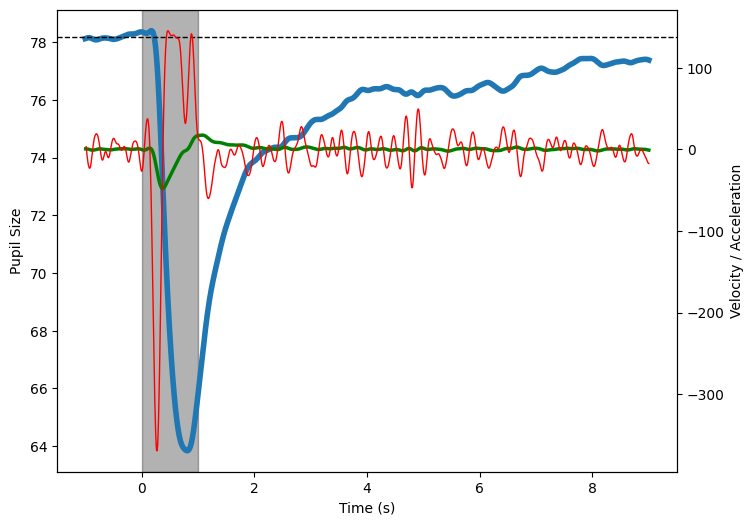

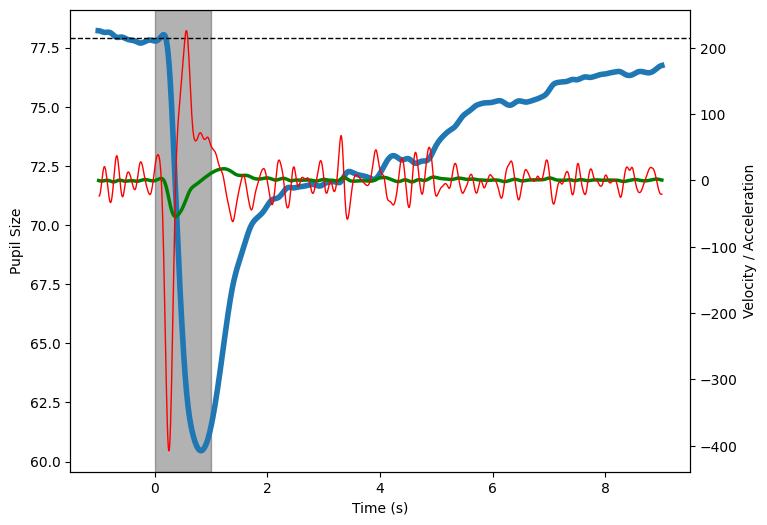

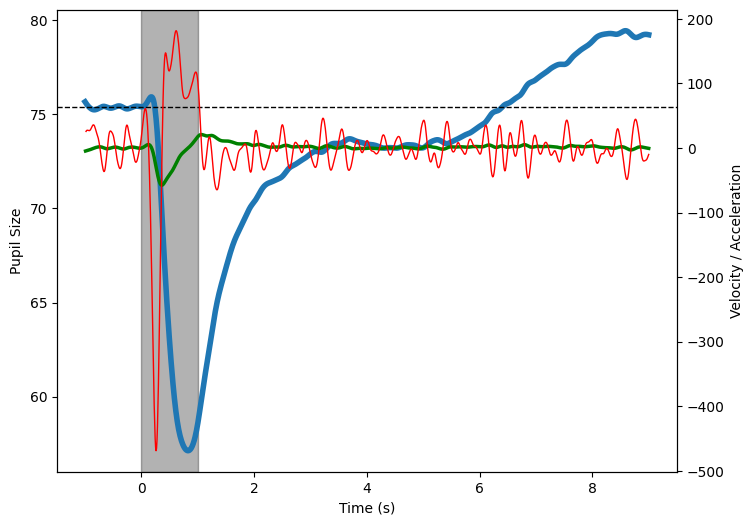

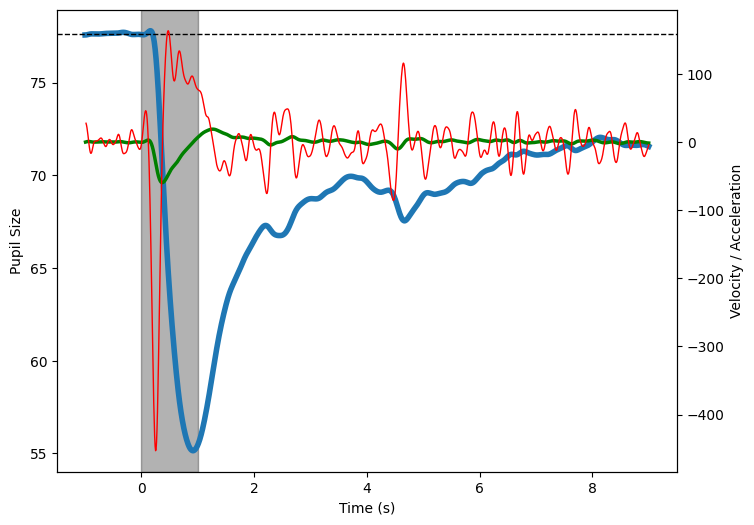

In [38]:

# Define the subject_id
subject_id = 'PJ25_A_PLR1'

rec_dir=f"{pup_config.data_dir}/{subject_id[:4]}/{subject_id}"
utils.print_file_structure(rec_dir)
pup_util.get_condition(subject_id)
import lr_preprocessing
importlib.reload(lr_preprocessing)
config=lr_preprocessing.create_process_config(0,"diameter",subject_id,pup_config.data_dir)
# Hier Ausgabeverzeichnis einstellen, ansonsten wird das Ergebnis bei den Eingabedateien gespeichert.
config.out_dir='/Users/Katharina/Desktop/PLR preprocessed'
print(config)
lr_preprocessing.process(config,display)

In [4]:
plr_all = [plr1, plr2, plr3, plr4]

for plr in plr_all:
    pyplr_result = get_pyplr_results(plr)
    pyplr_results["D1"].append(pyplr_result["D1"])
    pyplr_results["D2"].append(pyplr_result["D2"])
    pyplr_results["AMP"].append(pyplr_result["AMP"])
    pyplr_results["VCmax"].append(pyplr_result["VCmax"])
    pyplr_results["ACmax"].append(pyplr_result["ACmax"])
    pyplr_results["T1"].append(pyplr_result["T1"])
    pyplr_results["T2"].append(pyplr_result["T2"])
    pyplr_results["T3"].append(pyplr_result["T3"])
    pyplr_results["rel_AMP"].append(pyplr_result["rel_AMP"])
    pyplr_results["redil_75"].append(pyplr_result["redil_75"])
    pyplr_results["redil_50"].append(pyplr_result["redil_50"])
    pyplr_results["redil_25"].append(pyplr_result["redil_25"])




NameError: name 'plr1' is not defined

In [ ]:
df = pd.DataFrame(pyplr_results)
df["eye_id"] = "1"
df["method"] = "2d"


#always change the directory to what the sample gets saved 
df.to_csv(f"{pup_config.obj_dir}/{subject_id[:4]}/{subject_id}/pyplr_analysis/PLR_left_2d_results.csv", index=False)

print(df)
